In [11]:
#Basic libraries
import warnings
import tensorflow as ts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from collections import Counter
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from imblearn.over_sampling import RandomOverSampler

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score, precision_score,recall_score,f1_score

In [13]:
# Load the diabetes dataset
dataset= pd.read_csv('D:/PhD/Data Science/final_dataset.csv', sep = ',', index_col = 'id')

In [14]:
dataset.shape

(227804, 21)

In [15]:
dataset.columns

Index(['diabetes', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'health_issue',
       'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'],
      dtype='object')

In [16]:
# Assume that 'Diabetes_012' is the target variable
X = dataset.drop('diabetes', axis=1)
y = dataset['diabetes']

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
# Initialize the StratifiedShuffleSplit
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# Iterate over the splits
for train_index, test_index in stratified_splitter.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [18]:
# Train the Random Forest classifier using the pipeline
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# Evaluate the model on the original test set
original_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
print("Original Accuracy:", original_accuracy)

Original Accuracy: 0.8083887535392111


In [20]:
print("Accuracy Score:", round(accuracy_score(y_test, rf_model.predict(X_test)) * 100, 2))
print("precision score:", round(precision_score(y_test, rf_model.predict(X_test), pos_label='positive', average='weighted') * 100, 2))
print("recall score:", round(recall_score(y_test, rf_model.predict(X_test), pos_label='positive', average='weighted') * 100, 2))
print("Roc curve:",roc_auc_score(y, rf_model.predict_proba(X), multi_class='ovr').round(4)*100)
import sklearn.metrics as metrics
print("f1 score:", metrics.f1_score(y_test, rf_model.predict(X_test), pos_label='positive', average='weighted').round(4) * 100)

Accuracy Score: 80.84
precision score: 76.5
recall score: 80.84
Roc curve: 93.46
f1 score: 78.14


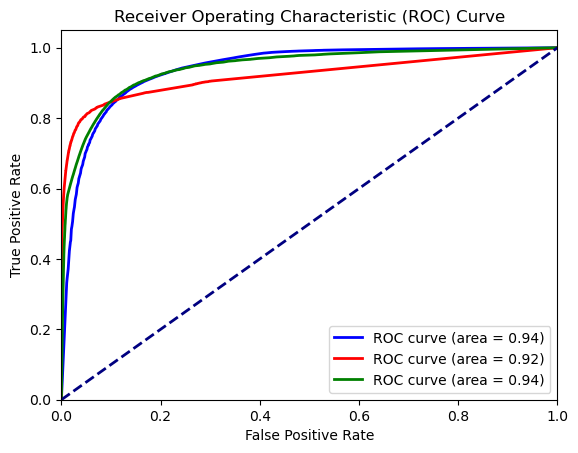

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
# Assuming rf_model is your model and X, y are your data and labels
# Assuming y has three classes (0, 1, and 2)
# Binarize the labels
y_bin = label_binarize(y, classes=[0, 1, 2])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], rf_model.predict_proba(X)[:, i])
    roc_auc[i] = roc_auc_score(y_bin[:, i], rf_model.predict_proba(X)[:, i])
# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# permutation_importance

In [ ]:
from sklearn.inspection import permutation_importance
# Calculate permutation importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=30, random_state=42)
# Get the permutation importance scores
perm_importance_scores = perm_importance.importances_mean
# Create a DataFrame to display feature names and their importance scores
perm_importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': perm_importance_scores})
# Sort the DataFrame by importance scores in descending order
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
# Display the permutation importance results
print("\nPermutation Importance:")
print(perm_importance_df)

# SHAP

In [ ]:
#Importing shap module
import shap
#intialize JS visualization
shap.initjs()

In [ ]:
#We will use below rows for prediction explanations using lime and shap
row = [100, 150,200, 250,300]

In [ ]:
#Shap tree explainer
shap_explainer = shap.TreeExplainer(model = rf_model, model_output='margin')
shap_values = shap_explainer.shap_values(X_test)

In [ ]:
#Shap decision plot
for i in row:
    print("for row :",i," the real value is ", y_test.iloc[i])
    shap.decision_plot(
    base_value=shap_explainer.expected_value[1],
    shap_values=shap_values[1][i],
    features=X_test.iloc[i],
    feature_names=X_test.columns.tolist(),
    link="identity",
    new_base_value=0.5
    )

In [ ]:
#bar chart
shap.summary_plot(shap_values = shap_values[1], features = X_test, max_display=20, plot_type='bar')

In [ ]:
#summary plot of shap X_train
shap_values = shap_explainer.shap_values(X_train)

In [ ]:
#shap summary plot of 
shap.summary_plot(shap_values, X_train, plot_type='bar')

# LIME

In [ ]:
# importing Lime
import lime
import lime.lime_tabular
#using tabuar explainer of lime
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
   X_train.values,
    training_labels=y_train.values,
    feature_names=X_train.columns.tolist(),
    feature_selection="auto",
    class_names  = ["0","1","2"],
)

In [ ]:
#Explanations using lime
for i in row:
    print("for row :",i," the real value is ", y_test.iloc[i])
    exp = lime_explainer.explain_instance(X_test.iloc[i], rf_model.predict_proba, num_features=5)
    exp.show_in_notebook(show_table=True)

In [ ]:
from sklearn.impute               
import SimpleImputer
from sklearn.pipeline 
import make_pipeline

In [ ]:
# Create a pipeline with imputation and Random Forest classification
rf_model = make_pipeline(
    SimpleImputer(strategy='mean', missing_values=np.nan),
    RandomForestClassifier(random_state=42)
)

In [ ]:
# Train the Random Forest classifier using the pipeline
rf_model.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the original test set
original_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
print("Original Accuracy:", original_accuracy)

In [ ]:
# Scenario 1: Leave-One-Column-Out (LOCO)

In [ ]:
# Iterate through each feature and evaluate the model after leaving out each feature
loco_accuracy = {}
for feature in X.columns:
    X_test_loco = X_test.copy()
    X_test_loco[feature] = np.nan
    loco_accuracy[feature] = accuracy_score(y_test, rf_model.predict(X_test_loco))

In [ ]:
# Display LOCO accuracies
print("\nLOCO Accuracies:")
for feature, accuracy in loco_accuracy.items():
    impact = original_accuracy - accuracy
    print(f"{feature}: Impact = {impact}")

In [ ]:
# Scenario 2: Removal-Based Explanations

In [ ]:
# Iterate through each feature and evaluate the model after removing each feature
removal_accuracy = {}
for feature in X.columns:
    X_test_removed = X_test.copy()
    X_test_removed[feature] = 0  # Replace the feature with a constant (e.g., 0)
    removal_accuracy[feature] = accuracy_score(y_test, rf_model.predict(X_test_removed))

In [ ]:
# Display Removal-Based Explanations accuracies
print("\nRemoval-Based Explanations Accuracies:")
for feature, accuracy in removal_accuracy.items():
    impact = original_accuracy - accuracy
    print(f"{feature}: Impact = {impact}")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
# Assuming rf_model is your model and X, y are your data and labels
# Assuming y has three classes (0, 1, and 2)
# Binarize the labels
y_bin = label_binarize(y, classes=[0, 1, 2])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], rf_model.predict_proba(X)[:, i])
    roc_auc[i] = roc_auc_score(y_bin[:, i], rf_model.predict_proba(X)[:, i])
# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()